In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

DATAPATH = Path("./data")
RESULTSPATH = Path("./results")
RNG = np.random.RandomState(952020)

In [2]:
def create_age_sample_from_mcmc_chains(dataset, sample_size=10000, random_state=RNG):
    dataset_path = DATAPATH/"mcmc_chains"/"campbell"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    dfs = []
    all_dataset_files = list(dataset_path.glob("*.tsv"))
    for i, sn_chain_path in enumerate(all_dataset_files):
        print(f"{i}/{len(all_dataset_files)}", end="\r")
        # Get number of rows in file
        # Header takes up 2 rows
        nheaders = 2
        nrows = sum(1 for line in open(sn_chain_path)) - nheaders
        skiprows = [1] + sorted(random_state.choice(range(nheaders, nrows+nheaders), nrows-sample_size, replace=False))

        _df = pd.read_table(sn_chain_path, skiprows=skiprows, usecols=[7], index_col=False)
        
        # Set the index as the SNID parsed from its filename
        snid = re.findall("SN(\d+)_", sn_chain_path.name)[0]
        _df['snid'] = [snid]*len(_df)
        dfs.append(_df)
    print(f"{len(all_dataset_files)}/{len(all_dataset_files)}", end="\r")
        
    df = pd.concat(dfs)
    df.to_csv(DATAPATH/f"{dataset}_local_samples.tsv", sep="\t")
    return 

def load_age_sample_from_mcmc_chains(dataset, mode="read", **kwargs):
    """Return a random sample of the mcmc chains dataset for all SNe available.

    dataset : str {"campbell", "campbellG", "gupta"} 
        Dataset to load.
    mode : str {"read", "write"}
        If write, redo the creation of the mcmc chain sample and also write to file.
        WARNING: this may take a long time sampling from ~20GB of data.
        If read, the mcmc chain sample is read from cached output of the "write" mode.
    **kwargs : keyword arguments
        Used when mode="write" and passed onto the function `create_age_sample_from_mcmc_chains`.
    """
    dataset_path = DATAPATH/"mcmc_chains"/"campbell"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    if mode == "write":
        return create_age_sample_from_mcmc_chains(dataset, **kwargs)
    if mode == "read":
        return pd.read_table(DATAPATH/f"{dataset}_local_samples.tsv")
    
def load_hr(dataset):
    """
    dataset : str {"campbell", "campbellG", "gupta"} 
        Dataset to load.
    """
    dataset_path = DATAPATH/"campbell_local_r19t1.txt"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    return ascii.read(dataset_path).to_pandas()

## Data

### Campbell HR and Age

In [3]:
# load_age_sample_from_mcmc_chains('campbell', mode="write")
age_df = load_age_sample_from_mcmc_chains('campbell', mode="read")
age_df = age_df.set_index("snid").sort_index()
display(age_df.head())

hr_df = load_hr("campbell")
hr_df = hr_df
hr_df.columns = hr_df.columns.str.lower()
hr_df = (hr_df.rename(columns={
    "sdss": "snid",
    "e_hr": "hr_err"
})
         .set_index("snid")
         .sort_index()[["hr", "hr_err"]])
display(hr_df.head())

in_age_not_hr = set(age_df.index) - set(hr_df.index)
in_hr_not_age = set(hr_df.index) - set(age_df.index)
print("Missing from R19 Table 1 of SNID:", in_age_not_hr)
print("Missing from Campbell MCMC chains of SNID:", in_hr_not_age)

print("Resulting data will be an inner join of the two")
age_df = age_df.drop(index=in_age_not_hr)
hr_df = hr_df.drop(index=in_hr_not_age)
snids = age_df.index.unique().tolist()

,age
snid,
762,2.021842
762,2.833909
762,2.580368
762,2.397617
762,2.629097


,hr,hr_err
snid,,
762,0.15,0.08
1032,-0.15,0.12
1371,-0.14,0.06
1794,0.27,0.08
2372,-0.12,0.07


Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two


## Correlation Analysis

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between ```Age_all``` and ```HR_all```.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a correlation, but it is not strong enough to deny dark energy
    4. there is a strong correlation, but slope is not large enough to deny dark energy
    5. there is a strong correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

### Statistical Simulation - Sampling Age and Hubble Residual
To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given it respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [4]:
def simulate(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_sample = RNG.choice(age_df.loc[snid, "age"], size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"hr_age_simulation.csv")

def get_simulation():
    return pd.read_csv(RESULTSPATH/"hr_age_simulation.csv")

simulate(age_df, hr_df)
result_df = get_simulation()

### Simulation Results

In [5]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

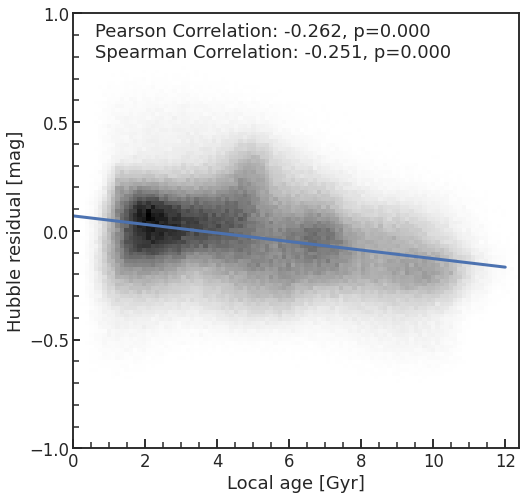

In [6]:
plt.figure(figsize=(8,8))
plt.hist2d(x, y, bins=100, cmap='gray_r')

xrange = np.linspace(0, 12, 100)
plt.plot(xrange, slope*xrange + intercept, lw=3)

plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.xlabel("Local age [Gyr]")
plt.ylabel("Hubble residual [mag]")
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(-1, 1.5, 0.5));

## Incorrect Correlation Analysis

Attempting to incorrectly do correlation analysis that L20 did which changes the previous correlation analysis by the assumption of the Age distribution:

* 10000 samples without replacement of Age assumed to be <span style="color: red">Gaussian parameters from the MCMC-derived posterior mean and SD</span>.

In [7]:
def simulate_incorrectly(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_dist = stats.norm(loc=age_df.loc[snid, 'age'].mean(), scale=age_df.loc[snid, 'age'].std()) 
        snid_age_dist.random_state = RNG
        snid_age_sample = snid_age_dist.rvs(size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"hr_age_incorrect_simulation.csv")

def get_incorrect_simulation():
    return pd.read_csv(RESULTSPATH/"hr_age_incorrect_simulation.csv")

# simulate_incorrectly(age_df, hr_df)
incorrect_result_df = get_incorrect_simulation()

In [8]:
x, y = incorrect_result_df['age'], incorrect_result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope = corr * (np.std(y) / np.std(x))
intercept = np.mean(y) - slope*np.mean(x)

([<matplotlib.axis.YTick at 0x7f18d53db0d0>,
 <a list of 5 Text major ticklabel objects>)

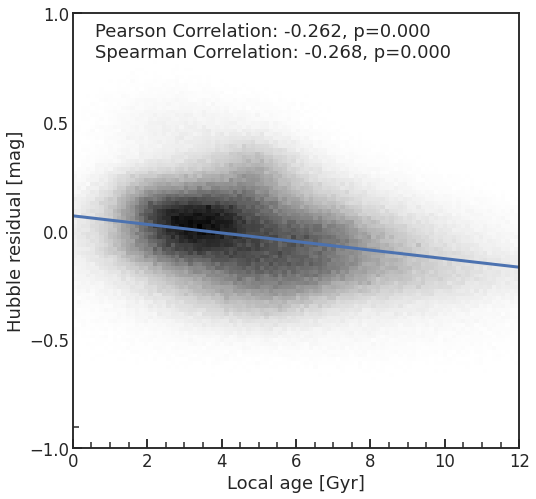

In [9]:
plt.figure(figsize=(8,8))
cut = (x > 0) & (x < 12)
plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')

xrange = np.linspace(0, 12, 100)
plt.plot(xrange, slope*xrange + intercept, lw=3)

plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.xlabel("Local age [Gyr]")
plt.ylabel("Hubble residual [mag]")
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(-1, 1.5, 0.5))

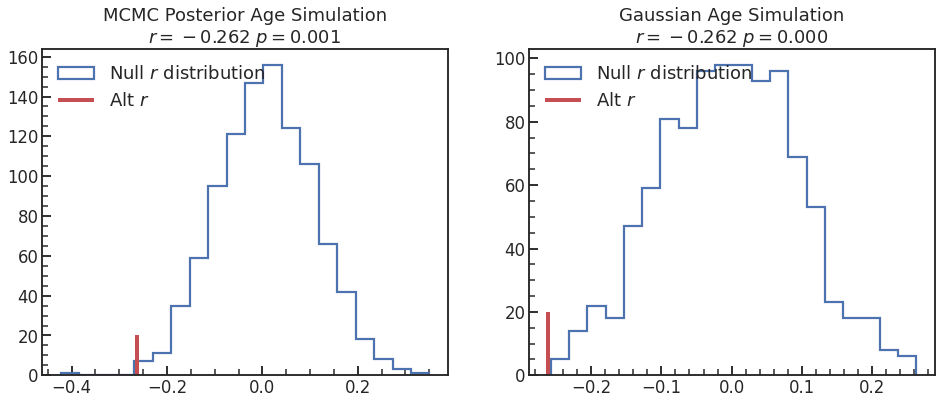

In [10]:
def correlation_test(x, y, corr_func=stats.pearsonr, sample_size=100, repetition=1000):
    """Test the significance of the correlation with null hypothesis of zero correlation"""
    corr = corr_func(x, y)[0] # We will ignore 2nd arg which is the p-value
    
    corr_samples = []
    for i in range(repetition):
        x_sample = np.random.choice(x, size=sample_size)
        y_sample = np.random.choice(y, size=sample_size)
        corr_sample = corr_func(x_sample, y_sample)[0]
        corr_samples.append(corr_sample)
    
    pvalue = np.mean(corr_samples <= corr)
    return corr, pvalue, corr_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax = axes[0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')

ax = axes[1]
_corr, _pvalue, _corr_samples = correlation_test(incorrect_result_df['age'], incorrect_result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')


## Summary

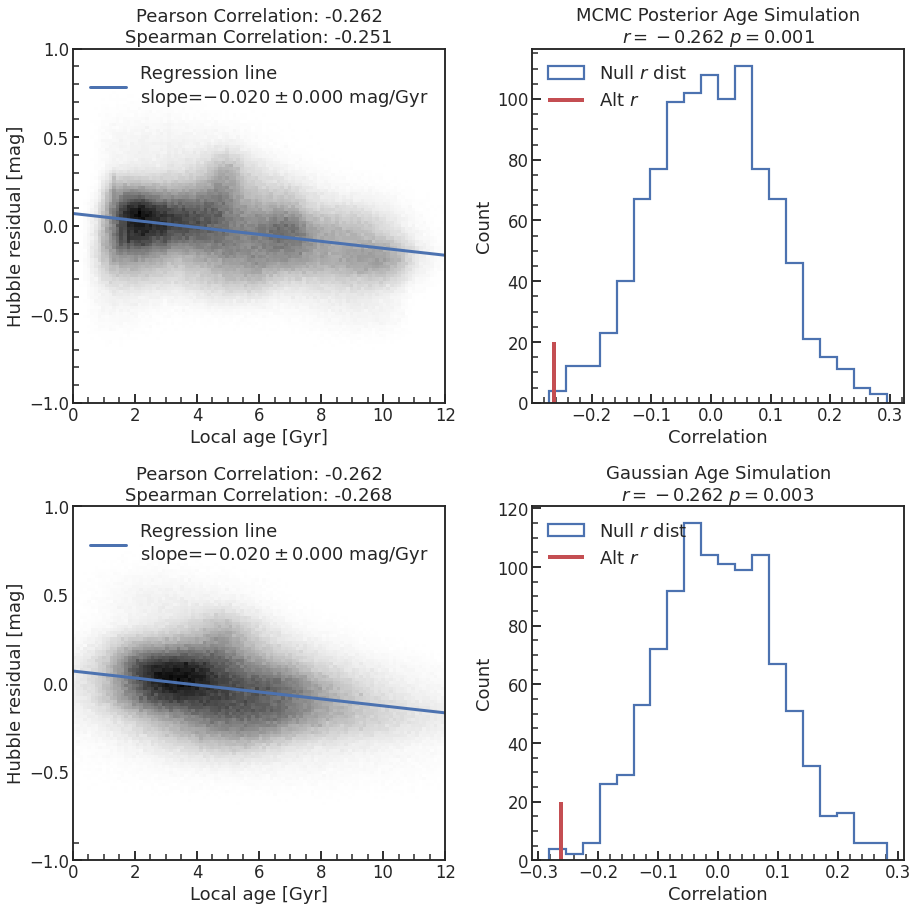

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))

# Correct Simulation
x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax = axes[0, 0]
cut = (x > 0) & (x < 12)
ax.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
xrange = np.linspace(0, 12, 100)
ax.plot(xrange, slope*xrange + intercept, lw=3, label=f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr")

ax.set_title(f"Pearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}")
ax.set_xlabel("Local age [Gyr]")
ax.set_ylabel("Hubble residual [mag]")
ax.set_xticks(np.arange(0, 14, 2))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.legend()

ax = axes[0, 1]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ dist")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
ax.legend(loc='upper left')

# Incorrect Simulation
x, y = incorrect_result_df['age'], incorrect_result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax = axes[1, 0]
cut = (x > 0) & (x < 12)
ax.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
xrange = np.linspace(0, 12, 100)
ax.plot(xrange, slope*xrange + intercept, lw=3, label=f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr")

ax.set_title(f"Pearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}")
ax.set_xlabel("Local age [Gyr]")
ax.set_ylabel("Hubble residual [mag]")
ax.set_xticks(np.arange(0, 14, 2))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.legend()

ax = axes[1, 1]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ dist")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
ax.legend(loc='upper left')

plt.tight_layout(h_pad=1)